# 作业：手写数字加法机

本文件是与集智AI学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [3]:
depth = [10, 20]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(1, 10, 5, padding = 2)
        self.net_pool = nn.MaxPool2d(2, 2)
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(1, 10, 5, padding = 2)
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
        #后面的全连阶层
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024)
        self.fc2 = nn.Linear(1024, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x, y, training = True):
        #第一张图像的处理流程
        x = F.relu(self.net1_conv1(x))
        x = self.net_pool(x)
        x = F.relu(self.net1_conv2(x))
        x = self.net_pool(x)
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #第二张图像的处理流程
        y = F.relu(self.net2_conv1(y))
        y = self.net_pool(y)
        y = F.relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)
        z = self.fc1(z)
        z = F.relu(z)
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z)
        z = F.relu(z)
        z = self.fc3(z)
#         z = F.log_softmax(z)
        return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y).type(torch.LongTensor)
    out = out.eq(target).sum() 
    out1 = y.size()[0]
    return(out, out1)

In [4]:
# 将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
results = {}

In [5]:
# 开始训练循环，本部分代码需要补齐
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    train_rights = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        net.train()
        outputs = net(Variable(x1), Variable(x2))
        labels = y1 + y2
        loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())
        right = rightness(outputs.data, labels)
        train_rights.append(right)
        if idx % 100 == 0:
            net.eval() # 给网络模型做标记，标志说模型在训练集上训练
            val_losses = [] #记录校验数据集损失
            val_rights = []
            for data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = data
                outputs = net(Variable(x1), Variable(x2))
                labels = y1 + y2  
                loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)))
                val_losses.append(loss.data.numpy())
                right = rightness(outputs.data, labels)
                val_rights.append(right)
            #每间隔一定周期就打印一下训练集、校验集的准确率结果
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 训练准确率：{:.2f}, 校验准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses),100. * train_r[0] / train_r[1],100. * val_r[0] / val_r[1]))
            records.append([np.mean(losses), np.mean(val_losses), 100 - 100. * train_r[0] / train_r[1],100 - 100. * val_r[0] / val_r[1]])

第0周期，第(0/938)个撮，训练误差：90.94, 校验误差：97.28, 训练准确率：4.69, 校验准确率：0.98
第0周期，第(100/938)个撮，训练误差：30.60, 校验误差：16.11, 训练准确率：7.66, 校验准确率：9.42
第0周期，第(200/938)个撮，训练误差：20.61, 校验误差：6.78, 训练准确率：9.93, 校验准确率：13.90
第0周期，第(300/938)个撮，训练误差：15.58, 校验误差：5.58, 训练准确率：12.18, 校验准确率：16.98
第0周期，第(400/938)个撮，训练误差：12.84, 校验误差：4.11, 训练准确率：13.91, 校验准确率：19.52
第0周期，第(500/938)个撮，训练误差：11.07, 校验误差：3.61, 训练准确率：15.29, 校验准确率：23.32
第0周期，第(600/938)个撮，训练误差：9.79, 校验误差：3.33, 训练准确率：16.70, 校验准确率：25.10
第0周期，第(700/938)个撮，训练误差：8.86, 校验误差：3.95, 训练准确率：17.75, 校验准确率：19.44
第0周期，第(800/938)个撮，训练误差：8.11, 校验误差：2.82, 训练准确率：18.82, 校验准确率：28.60
第0周期，第(900/938)个撮，训练误差：7.53, 校验误差：2.62, 训练准确率：19.68, 校验准确率：28.56
第1周期，第(0/938)个撮，训练误差：2.84, 校验误差：2.65, 训练准确率：26.56, 校验准确率：28.92
第1周期，第(100/938)个撮，训练误差：2.40, 校验误差：2.44, 训练准确率：28.57, 校验准确率：30.70
第1周期，第(200/938)个撮，训练误差：2.38, 校验误差：2.34, 训练准确率：29.16, 校验准确率：33.16
第1周期，第(300/938)个撮，训练误差：2.35, 校验误差：2.24, 训练准确率：29.52, 校验准确率：33.40
第1周期，第(400/938)个撮，训练误差：2.33, 校验误差：2.13, 训练准确率：29.79, 校验准确率：32.36
第1周期，第(500/938)个撮，训练误差：2.2

第12周期，第(600/938)个撮，训练误差：0.49, 校验误差：0.61, 训练准确率：71.77, 校验准确率：75.76
第12周期，第(700/938)个撮，训练误差：0.49, 校验误差：0.58, 训练准确率：71.85, 校验准确率：76.20
第12周期，第(800/938)个撮，训练误差：0.48, 校验误差：0.60, 训练准确率：72.03, 校验准确率：75.60
第12周期，第(900/938)个撮，训练误差：0.47, 校验误差：0.57, 训练准确率：72.38, 校验准确率：76.32
第13周期，第(0/938)个撮，训练误差：0.85, 校验误差：0.61, 训练准确率：68.75, 校验准确率：76.78
第13周期，第(100/938)个撮，训练误差：0.42, 校验误差：0.60, 训练准确率：74.16, 校验准确率：76.16
第13周期，第(200/938)个撮，训练误差：0.43, 校验误差：0.58, 训练准确率：74.03, 校验准确率：76.60
第13周期，第(300/938)个撮，训练误差：0.43, 校验误差：0.59, 训练准确率：73.89, 校验准确率：76.16
第13周期，第(400/938)个撮，训练误差：0.42, 校验误差：0.60, 训练准确率：73.83, 校验准确率：76.62
第13周期，第(500/938)个撮，训练误差：0.43, 校验误差：0.56, 训练准确率：73.84, 校验准确率：77.80
第13周期，第(600/938)个撮，训练误差：0.43, 校验误差：0.59, 训练准确率：74.20, 校验准确率：74.78
第13周期，第(700/938)个撮，训练误差：0.44, 校验误差：0.60, 训练准确率：74.22, 校验准确率：75.50
第13周期，第(800/938)个撮，训练误差：0.43, 校验误差：0.55, 训练准确率：74.34, 校验准确率：78.06
第13周期，第(900/938)个撮，训练误差：0.43, 校验误差：0.72, 训练准确率：74.59, 校验准确率：75.06
第14周期，第(0/938)个撮，训练误差：0.38, 校验误差：0.58, 训练准确率：67.19, 校验准确率：78.28
第14周期，第(100/93

In [20]:
outputs


Variable containing:
1.00000e-02 *
 -7.3010
 -5.2101
 -3.4039
 -3.4332
 -3.8772
  0.0722
 -1.9004
 -0.1965
 -2.4382
 -1.4105
 -5.7852
 -0.9731
  1.1149
 -3.6330
 -2.7798
 -6.6657
 -2.1807
 -1.0427
 -3.9827
 -0.0726
 -0.0899
 -4.3419
 -1.7035
 -2.5341
 -7.5184
 -2.4529
 -0.5291
 -5.0590
  0.9535
 -1.7753
 -5.5099
 -4.5778
 -0.3546
 -2.4741
 -5.1842
 -4.7221
 -3.8964
 -2.3389
 -4.3837
 -1.9101
 -3.7503
 -1.4272
 -1.3684
 -1.3880
 -8.1556
 -4.6628
 -6.0483
 -1.2856
 -0.5653
 -4.6730
 -4.4303
 -3.3136
 -1.4424
 -2.4305
 -2.8994
 -2.2516
 -2.0164
 -4.1535
 -4.3426
 -0.7684
 -1.6155
  2.6002
 -3.9082
 -7.0374
[torch.FloatTensor of size 64x1]

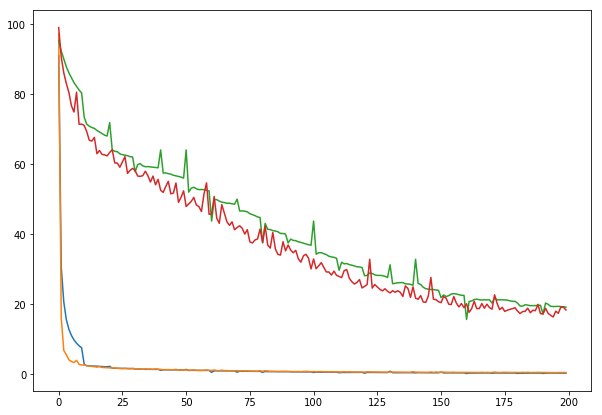

In [6]:
# 在测试集上运行我们的加法机网络，并测试预测准确度
plt.figure(figsize = (10, 7))
plt.plot(records) 



In [7]:
net.eval()
test_rights = []
for data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = data
    outputs = net(Variable(x1), Variable(x2))
    labels = y1 + y2
    right = rightness(outputs.data, labels)
    test_rights.append(right)
test_r = (sum([tup[0] for tup in test_rights]), sum([tup[1] for tup in test_rights]))
right_rate = 1.0 * test_r[0] / test_r[1]
right_rate

0.9078